In [32]:
from os import times_result
from random import random
from typing import final
import numpy as np
# from torch import R
from da_ot import OTGroupLassoDAClassifier, OTBFBDAClassifier
from data import Xt_all, load_battery_data, load_battery_data_random, load_battery_data_split
from plot import plot_continuous_domain_adaptation, plot_accuracies

from sklearn import ensemble
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn import tree
import random

def test_cdot_methods(methods, time_reg_vector, n_samples_source, n_samples_targets,
                      time_length, time_series, methods_names=None, cost="seq",
                      fig_name=None, plot_mapping=False, random_seed = 0):
    
    # Xs, ys, Xt, yt, Xt_all, yt_all = load_battery_data(n_samples_source, n_samples_targets, time_length, True)
    # Xs, ys, Xt, yt, Xt_all, yt_all = load_battery_data_random(n_samples_source, n_samples_targets, time_series, shuffle_or_not = True, random_seed = random_seed)
    Xs, ys, Xt, yt, Xt_all, yt_all, acc, _, _ = load_battery_data_split(n_samples_source, n_samples_targets, time_series, shuffle_or_not = True, random_seed = random_seed, train_set = 20)

    mapped_samples = []
    time_reg = []
    entropic_reg = []

    scores = np.zeros([len(methods), time_length])
    losses = np.zeros([len(methods), time_length])
    ots = np.arange(time_length)

    for m, da_clf in enumerate(methods):
        # print("Running ", methods_names[m])
        temp_samples = []
        for k in range(time_length):
            if k > 0:
                if cost == "seq":
                    da_clf.fit(temp_samples[-1], ys, Xt[k], treg=time_reg_vector[m], Gamma_old=da_clf.Gamma,
                               Xt_old=Xt[k - 1])

                    time_reg.append(da_clf.temp_reg(da_clf.Gamma))
                    # print("time_reg: ", time_reg)
                    entropic_reg.append(da_clf.entropic_reg(da_clf.Gamma))
                    # print("entropic reg: ", entropic_reg)
                    # print("--seq oting--")
                else:
                    # da_clf.fit(Xs, ys, Xt[k], treg=time_reg_vector[m], Gamma_old=da_clf.Gamma,
                    #            Xt_old=Xt[k - 1])
                    da_clf.fit(Xs, ys, Xt[k])
                    # print("--direct oting--")

            else:
                da_clf.fit(Xs, ys, Xt[k])

            temp_samples.append(da_clf.adapt_source_to_target())
            
            result = da_clf.predict(Xt_all[k])
            scores[m, k] = r2_score(yt_all[k], result)
            losses[m, k] = mean_squared_error(yt_all[k], result)

        mapped_samples.append(temp_samples)
        
        
        # if plot_mapping:
        #     for k in range(time_length):
        #         plot_continuous_domain_adaptation(Xt, yt, mapped_samples, ys, methods_names=methods_names, time_idx=k,
        #                                           fig_name=fig_name + "_time_" + str(
        #                                               k) + "_geom.png" if fig_name is not None else None)

    # plot_accuracies(ots, scores, methods_names=methods_names,
    #                 fig_name='./fig/' + fig_name + "_" + str(time_length) + "_accuracy.png" if fig_name is not None else None)
    # plot_accuracies(ots, losses, methods_names=methods_names,
    #                 fig_name='./fig/' + fig_name + "_" + str(time_length) + "_loss.png" if fig_name is not None else None)
  

    return scores, losses, ots, time_reg, entropic_reg, acc


In [106]:
N_RUNS = 10

# clf = KNeighborsClassifier(n_neighbors=1)
# clf = ensemble.RandomForestRegressor(n_estimators=4)
# clf = Ridge(alpha=5)
clf = svm.SVR()
# clf = tree.DecisionTreeRegressor()


ot_group_lasso = OTGroupLassoDAClassifier(clf, reg=0.5, eta=10)
ot_group_lasso_treg = OTGroupLassoDAClassifier(clf, reg=0.5, eta=10)
ot_BFB = OTBFBDAClassifier(clf, reg=0.1, regnorm=None, it=50, epochs=1000, lr=10, verbose=True)

# methods = [ot_group_lasso, ot_group_lasso_treg, ot_BFB]
# methods_names =  ['ot_group_lasso', 'ot_group_lasso_treg', 'ot_BFB']
# time_reg_vector = [0, 50, 50]

methods = [ot_BFB]
methods_names =  ['ot_BFB']
time_reg_vector = [50]

per_epoch_loss_order = []
per_epoch_loss_direct = []

clf_acc = []

for sd in range(100):
    print("#epoch {}".format(sd))
    np.random.seed(sd)
    # time = np.random.randint(1, 10)
    time = 3
    # ot_series = 5 * np.random.randint(2, 10, time)
    ot_series = 5 * (np.random.choice(9, time, replace=False) + 2)

    sorted_ot_series = ot_series

    
    # sorted_ot_series = sorted_ot_series[np.where(sorted_ot_series <= sorted_ot_series[-1])]
    sorted_ot_series = np.sort(sorted_ot_series)

    sample_num = len(sorted_ot_series) - 1
    unsorted_ot_series = sorted_ot_series
    if sample_num > 0 and time > 1:
        unsorted_ot_series = 5 * (np.random.choice(9, sample_num, replace=False) + 2)
        unsorted_ot_series = np.append(unsorted_ot_series, sorted_ot_series[-1])
    

    # # ------------------------

    # sorted_ot_series = sorted_ot_series[np.where(sorted_ot_series <= sorted_ot_series[-1])]
    # sorted_ot_series = np.sort(sorted_ot_series)

    # sample_num = len(sorted_ot_series) - 1
    # unorder_sd = 0
    # unsorted_ot_series = sorted_ot_series
    # if sample_num > 0 and time > 1:
    #     random.seed(unorder_sd)
    #     sample_list = [i for i in range(time - 1)]
    #     sample_list = random.sample(sample_list, sample_num)

    #     unsorted_ot_series = ot_series[sample_list]
    #     unsorted_ot_series = np.append(unsorted_ot_series, ot_series[-1])


    # # ------------------------
    time = len(sorted_ot_series)
    target = 20
    cost = ["seq", "direct"]
    final_scores = np.zeros([len(cost), time])
    final_losses = np.zeros([len(cost), time])

    final_scores_var = np.zeros([len(cost), time])
    final_losses_var = np.zeros([len(cost), time])

    for i, c in enumerate(cost):
        # print('-----{} ot-----'.format(c))

        run_scores = []
        run_losses = []

        for run in range(N_RUNS):
            # print("RUN %d..." % run)
            scores, losses, ots, time_reg, entropic_reg, acc = test_cdot_methods(
                methods=methods,
                methods_names=methods_names,
                time_reg_vector=time_reg_vector,
                fig_name="seq_run_" + str(run),
                time_length=time,
                time_series=sorted_ot_series,
                n_samples_source=67,
                n_samples_targets=target,
                plot_mapping=False,
                cost=c,
                random_seed = sd * (run+1)
            )
            run_scores.append(scores)
            run_losses.append(losses)
            # print('----scores----')
            # print(scores)
            # print('----losses----')
            # print(losses)
            clf_acc.append(acc)

        avg_scores = np.mean(np.array(run_scores), axis=0)
        score_var = np.var(np.array(run_scores), axis=0)
        
        avg_losses = np.mean(np.array(run_losses), axis=0)
        loss_var = np.var(np.array(run_losses), axis=0)

        final_scores[i, :] = avg_scores
        final_losses[i, :] = avg_losses

        final_scores_var[i, :] = score_var
        final_losses_var[i, :] = loss_var
    
    per_epoch_loss_order.append(final_losses[0, -1])
    per_epoch_loss_direct.append(final_losses[1, -1])

    # print("ot series: ", ot_series)
    # print("sorted ot series: ", sorted_ot_series)
    # print("unsorted ot series: ", unsorted_ot_series)
    # print("average loss: ", final_losses[:, -1])
    # plot_accuracies(ots, sorted_ot_series, final_scores, final_scores_var, methods_names=cost, fig_name="./set1.4_fig/" + "{}_random_s05_run_{}_tcnt_{}_avg_accuracy.png".format(sd, time, target))
    # plot_accuracies(ots, sorted_ot_series, final_losses, final_losses_var, methods_names=cost, fig_name="./set1.4_fig/" + "{}_len{}_ot{}_seq{:.5f}_dire{:.5f}.png".format(sd, time, sorted_ot_series, final_losses[0, -1], final_losses[1, -1]))

avg_clf_acc = np.mean(clf_acc)
print(avg_clf_acc)


#epoch 0
#epoch 1
#epoch 2
#epoch 3
#epoch 4
#epoch 5
#epoch 6
#epoch 7
#epoch 8
#epoch 9
#epoch 10
#epoch 11
#epoch 12
#epoch 13
#epoch 14
#epoch 15
#epoch 16
#epoch 17
#epoch 18
#epoch 19
#epoch 20
#epoch 21
#epoch 22
#epoch 23
#epoch 24
#epoch 25
#epoch 26
#epoch 27
#epoch 28
#epoch 29
#epoch 30
#epoch 31
#epoch 32
#epoch 33
#epoch 34
#epoch 35
#epoch 36
#epoch 37
#epoch 38
#epoch 39
#epoch 40
#epoch 41
#epoch 42
#epoch 43
#epoch 44
#epoch 45
#epoch 46
#epoch 47
#epoch 48
#epoch 49
#epoch 50
#epoch 51
#epoch 52
#epoch 53
#epoch 54
#epoch 55
#epoch 56
#epoch 57
#epoch 58
#epoch 59
#epoch 60
#epoch 61
#epoch 62
#epoch 63
#epoch 64
#epoch 65
#epoch 66
#epoch 67
#epoch 68
#epoch 69
#epoch 70
#epoch 71
#epoch 72
#epoch 73
#epoch 74
#epoch 75
#epoch 76
#epoch 77
#epoch 78
#epoch 79
#epoch 80
#epoch 81
#epoch 82
#epoch 83
#epoch 84
#epoch 85
#epoch 86
#epoch 87
#epoch 88
#epoch 89
#epoch 90
#epoch 91
#epoch 92
#epoch 93
#epoch 94
#epoch 95
#epoch 96
#epoch 97
#epoch 98
#epoch 99
0.70921985

In [107]:
time_reg

[]

In [108]:
entropic_reg

[]

In [109]:
len(per_epoch_loss_order)
print("mean of order ", np.mean(per_epoch_loss_order))
print("mean of direct ", np.mean(per_epoch_loss_direct))
print("var of order ", np.var(per_epoch_loss_order))
print("var of direct ", np.var(per_epoch_loss_direct))

mean of order  0.022762556570037805
mean of direct  0.09761972525263443
var of order  2.6814754883280205e-05
var of direct  0.0008380144665490642


In [112]:
N_RUNS = 10

clf = svm.SVR()

ot_group_lasso = OTGroupLassoDAClassifier(clf, reg=0.5, eta=10)
ot_group_lasso_treg = OTGroupLassoDAClassifier(clf, reg=0.5, eta=10)
ot_BFB = OTBFBDAClassifier(clf, reg=0.1, regnorm=None, it=50, epochs=1000, lr=10, verbose=True)

# methods = [ot_group_lasso, ot_group_lasso_treg, ot_BFB]
# methods_names =  ['ot_group_lasso', 'ot_group_lasso_treg', 'ot_BFB']
# time_reg_vector = [0, 50, 50]

methods = [ot_BFB]
methods_names =  ['ot_BFB']
time_reg_vector = [50]

per_epoch_loss_unorder = []

clf_acc = []

for sd in range(100):
    print("#epoch {}".format(sd))
    np.random.seed(sd)
    time = 3
    # time = np.random.randint(1, 10)
    # ot_series = 5 * np.random.randint(2, 10, time)
    ot_series = 5 * (np.random.choice(9, time, replace=False) + 2)

    sorted_ot_series = ot_series

    
    sorted_ot_series = np.sort(sorted_ot_series)

    sample_num = len(sorted_ot_series) - 1
    unsorted_ot_series = sorted_ot_series
    if sample_num > 0 and time > 1:
        unsorted_ot_series = 5 * (np.random.choice(9, sample_num, replace=False) + 2)
        unsorted_ot_series = np.append(unsorted_ot_series, sorted_ot_series[-1])
    

    # # ----------

    # sorted_ot_series = sorted_ot_series[np.where(sorted_ot_series <= sorted_ot_series[-1])]
    # sorted_ot_series = np.sort(sorted_ot_series)

    # sample_num = len(sorted_ot_series) - 1
    # unorder_sd = 0
    # unsorted_ot_series = sorted_ot_series
    # if sample_num > 0 and time > 1:
    #     random.seed(unorder_sd)
    #     sample_list = [i for i in range(time - 1)]
    #     sample_list = random.sample(sample_list, sample_num)

    #     unsorted_ot_series = ot_series[sample_list]
    #     unsorted_ot_series = np.append(unsorted_ot_series, ot_series[-1])

    # # ----------
    
    sorted_ot_series = unsorted_ot_series

    time = len(sorted_ot_series)
    target = 20
    cost = ["seq"]
    final_scores = np.zeros([len(cost), time])
    final_losses = np.zeros([len(cost), time])

    final_scores_var = np.zeros([len(cost), time])
    final_losses_var = np.zeros([len(cost), time])

    for i, c in enumerate(cost):
        # print('-----{} ot-----'.format(c))

        run_scores = []
        run_losses = []

        for run in range(N_RUNS):
            # print("RUN %d..." % run)
            scores, losses, ots, time_reg, entropic_reg, acc = test_cdot_methods(
                methods=methods,
                methods_names=methods_names,
                time_reg_vector=time_reg_vector,
                fig_name="seq_run_" + str(run),
                time_length=time,
                time_series=sorted_ot_series,
                n_samples_source=67,
                n_samples_targets=target,
                plot_mapping=False,
                cost=c,
                random_seed = sd * (run+1)
            )
            run_scores.append(scores)
            run_losses.append(losses)
            # print('----scores----')
            # print(scores)
            # print('----losses----')
            # print(losses)
            clf_acc.append(acc)

        avg_scores = np.mean(np.array(run_scores), axis=0)
        score_var = np.var(np.array(run_scores), axis=0)
        
        avg_losses = np.mean(np.array(run_losses), axis=0)
        loss_var = np.var(np.array(run_losses), axis=0)

        final_scores[i, :] = avg_scores
        final_losses[i, :] = avg_losses

        final_scores_var[i, :] = score_var
        final_losses_var[i, :] = loss_var

    per_epoch_loss_unorder.append(final_losses[0, -1])
    # print("ot series: ", ot_series)
    # print("sorted ot series: ", sorted_ot_series)
    # print("unsorted ot series: ", unsorted_ot_series)
    # print("average loss: ", final_losses[:, -1])
    # plot_accuracies(ots, sorted_ot_series, final_scores, final_scores_var, methods_names=cost, fig_name="./set1.2_fig/" + "{}_random_s05_run_{}_tcnt_{}_avg_accuracy.png".format(sd, time, target))
    # plot_accuracies(ots, sorted_ot_series, final_losses, final_losses_var, methods_names=cost, fig_name="./set1.2_fig/" + "{}_sd2_{}_len{}_ot{}_seq{:.5f}_dire{:.5f}.png".format(sd, unorder_sd, time, ot_series, final_losses[0, -1], final_losses[1, -1]))

avg_clf_acc = np.mean(clf_acc)
print(avg_clf_acc)


#epoch 0
#epoch 1
#epoch 2
#epoch 3
#epoch 4
#epoch 5
#epoch 6
#epoch 7


In [111]:
per_epoch_loss_unorder
print(np.mean(per_epoch_loss_unorder))
print(np.var(per_epoch_loss_unorder))

0.024863301026963186
0.00010438354510823178


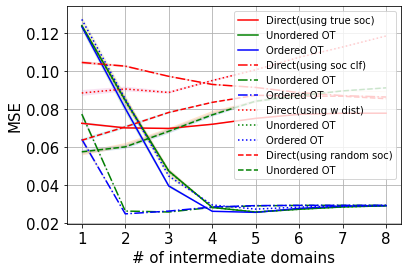

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('soc_soc_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], color = 'r', label = 'Direct(using true soc)')
plt.plot(x, data['mean_unorder'], color = 'g', label = 'Unordered OT')
plt.plot(x, data['mean_order'], color = 'b', label = 'Ordered OT')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

data = pd.read_csv('soc_clf_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], '-.', color = 'r', label = 'Direct(using soc clf)')
plt.plot(x, data['mean_unorder'], '-.', color = 'g', label = 'Unordered OT')
plt.plot(x, data['mean_order'], '-.', color = 'b', label = 'Ordered OT')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

data = pd.read_csv('soc_w_dis_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], ':', color = 'r', label = 'Direct(using w dist)')
plt.plot(x, data['mean_unorder'], ':', color = 'g', label = 'Unordered OT')
plt.plot(x, data['mean_order'], ':', color = 'b', label = 'Ordered OT')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

data = pd.read_csv('soc_random_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], '--', color = 'r', label = 'Direct(using random soc)')
plt.plot(x, data['mean_unorder'], '--', color = 'g', label = 'Unordered OT')
# plt.plot(x, data['mean_order'], '--', color = 'b', label = 'Ordered OT')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

plt.grid()
plt.xlabel('# of intermediate domains', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
# plt.title('using soc clf', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
# plt.savefig('./pics/dgprwomlp5.png', dpi=500, bbox_inches='tight')

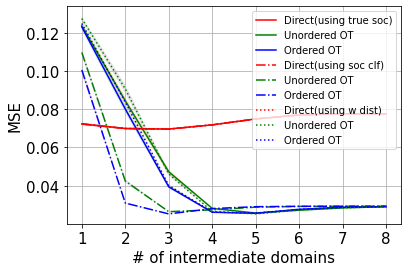

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('soc_soc_pc_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], color = 'r', label = 'Direct(using true soc)')
plt.plot(x, data['mean_unorder'], color = 'g', label = 'Unordered OT')
plt.plot(x, data['mean_order'], color = 'b', label = 'Ordered OT')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

# data = pd.read_csv('soc_soc_10.csv')
# x = range(1, len(data['mean_direct']) + 1)
# plt.plot(x, data['mean_direct'], color = 'r', label = 'Direct(using true soc)')
# plt.plot(x, data['mean_unorder'], color = 'g', label = 'Unordered OT')
# plt.plot(x, data['mean_order'], color = 'b', label = 'Ordered OT')
# plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
# plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
# plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)


data = pd.read_csv('soc_clf_sametarget_pc_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], '-.', color = 'r', label = 'Direct(using soc clf)')
plt.plot(x, data['mean_unorder'], '-.', color = 'g', label = 'Unordered OT')
plt.plot(x, data['mean_order'], '-.', color = 'b', label = 'Ordered OT')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

# data = pd.read_csv('soc_clf_10.csv')
# x = range(1, len(data['mean_direct']) + 1)
# plt.plot(x, data['mean_direct'], '-', color = 'r', label = 'Direct(using soc clf)')
# plt.plot(x, data['mean_unorder'], '-', color = 'g', label = 'Unordered OT')
# plt.plot(x, data['mean_order'], '-', color = 'b', label = 'Ordered OT')
# plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
# plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
# plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)


data = pd.read_csv('soc_w_dis_sametarget_pc_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], ':', color = 'r', label = 'Direct(using w dist)')
plt.plot(x, data['mean_unorder'], ':', color = 'g', label = 'Unordered OT')
plt.plot(x, data['mean_order'], ':', color = 'b', label = 'Ordered OT')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

# data = pd.read_csv('soc_random_sametarget_10.csv')
# x = range(1, len(data['mean_direct']) + 1)
# plt.plot(x, data['mean_direct'], '--', color = 'r', label = 'Direct(using random soc)')
# plt.plot(x, data['mean_unorder'], '--', color = 'g', label = 'Unordered OT')
# # plt.plot(x, data['mean_order'], '--', color = 'b', label = 'Ordered OT')
# plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
# plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
# plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

plt.grid()
plt.xlabel('# of intermediate domains', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
# plt.title('using soc clf', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
# plt.savefig('./pics/dgprwomlp5.png', dpi=500, bbox_inches='tight')

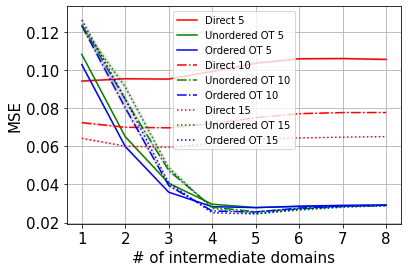

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('soc_soc_5.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], color = 'r', label = 'Direct 5')
plt.plot(x, data['mean_unorder'], color = 'g', label = 'Unordered OT 5')
plt.plot(x, data['mean_order'], color = 'b', label = 'Ordered OT 5')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

data = pd.read_csv('soc_soc_10.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], '-.', color = 'r', label = 'Direct 10')
plt.plot(x, data['mean_unorder'], '-.', color = 'g', label = 'Unordered OT 10')
plt.plot(x, data['mean_order'], '-.', color = 'b', label = 'Ordered OT 10')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

data = pd.read_csv('soc_soc_15.csv')
x = range(1, len(data['mean_direct']) + 1)
plt.plot(x, data['mean_direct'], ':', color = 'r', label = 'Direct 15')
plt.plot(x, data['mean_unorder'], ':', color = 'g', label = 'Unordered OT 15')
plt.plot(x, data['mean_order'], ':', color = 'b', label = 'Ordered OT 15')
plt.fill_between(x, data['mean_direct'] - data['var_direct'], data['mean_direct'] + data['var_direct'], alpha = 0.2)
plt.fill_between(x, data['mean_unorder'] - data['var_unorder'], data['mean_unorder'] + data['var_unorder'], alpha = 0.2)
plt.fill_between(x, data['mean_order'] - data['var_order'], data['mean_order'] + data['var_order'], alpha = 0.2)

plt.grid()
plt.xlabel('# of intermediate domains', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
# plt.title('using true soc', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
# plt.savefig('./pics/dgprwomlp5.png', dpi=500, bbox_inches='tight')